# MC62 — Eddy Current Settling Analysis — `01_staircase_with_shims`

**Magnet**: MC62 (red bulk C-shaped dipole)
**Machine**: LEAR antiproton decelerator, CERN
**Test**: `01_staircase_with_shims` — full hysteresis staircase (2026-02-11)
**Current cycle**: 0 → +200 → 0 → −200 → 0 A in 20 A steps (41 plateaus, 350 turns each)
**Rotation speed**: −60 rpm (1 turn ≈ 1 s)

---

## Theory: Eddy Currents in Laminated Yoke Magnets

When the excitation current steps to a new level, eddy currents are induced in the
conducting iron yoke laminations. These currents produce a transient magnetic field
that decays exponentially:

$$B_1(t) = B_{1,\infty} + A \cdot \exp\!\left(-\frac{t}{\tau}\right)$$

The time constant for a laminated yoke with lamination thickness $d$, conductivity
$\sigma$, and local permeability $\mu_r$ is:

$$\tau = \frac{\mu_0 \, \mu_r(H) \, \sigma \, d^2}{\pi^2}$$

**Key insight**: $\mu_r$ depends on the magnetization level. At low current (unsaturated
iron), $\mu_r \approx 2000$–$5000$, giving large $\tau$. At high current (approaching
saturation), $\mu_r$ drops significantly, and $\tau$ shrinks. This notebook quantifies
this dependence across the full staircase cycle.

**Companion notebook**: See
[`analysis_20260211_114759_LEAR_MC62_01_staircase_with_shims.ipynb`](analysis_20260211_114759_LEAR_MC62_01_staircase_with_shims.ipynb)
for the main harmonic analysis using `N_LAST_TURNS = 170`.

## 1. Configuration

In [1]:
from pathlib import Path

# ── Paths ──────────────────────────────────────────────────────────────
BASE_DIR    = Path(r"C:\Users\albellel\python-projects\rotating-coil-analyzer\measurements\2026_02_11_MC62")
TEST_DIR    = BASE_DIR / "01_staircase_with_shims" / "20260211_114759_staircase_MC62"
RUN_DIR     = TEST_DIR / "20260211_133720_MC62"
KN_DIR      = BASE_DIR / "Kn values"

KN_INTEGRAL = KN_DIR / "Kn_R45_PCB_N1_0001_A_AC.txt"       # integral (long) PCB

# ── Magnet & coil parameters ──────────────────────────────────────────
MAGNET_ORDER     = 1        # dipole
R_REF            = 0.033    # reference radius [m]  (2/3 of 50 mm half-gap)
SAMPLES_PER_TURN = 1024     # encoder resolution
RPM              = 60       # rotation speed [rpm]
T_PER_TURN       = 60.0 / RPM  # ≈ 1.0 s per turn

# ── Pipeline options ──────────────────────────────────────────────────
OPTIONS    = ("dri", "rot", "cel", "fed")
DRIFT_MODE = "legacy"
MIN_B1_T   = 1e-6           # warm dipole: lower threshold for ok_main
MAX_ZR     = 0.01

# ── Settling analysis parameters ─────────────────────────────────────
N_SETTLED       = 50        # last N turns used as "settled" reference
N_SHOW_SETTLING = 200       # turns to show in settling plots
MIN_I_FOR_FIT   = 10.0      # minimum |I_nom| for exponential fit [A]

print(f"MC62 Eddy Current Analysis")
print(f"  Test: 01_staircase_with_shims")
print(f"  Rotation: {RPM} rpm -> {T_PER_TURN:.2f} s/turn")
print(f"  Settled reference: last {N_SETTLED} turns")

MC62 Eddy Current Analysis
  Test: 01_staircase_with_shims
  Rotation: 60 rpm -> 1.00 s/turn
  Settled reference: last 50 turns


## 2. Imports

In [2]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

%matplotlib widget

plt.rcParams.update({
    "figure.figsize": (14, 5),
    "axes.grid": True,
    "grid.alpha": 0.3,
    "figure.dpi": 110,
})

from rotating_coil_analyzer.analysis.kn_pipeline import load_segment_kn_txt
from rotating_coil_analyzer.analysis.utility_functions import (
    process_kn_pipeline,
    build_harmonic_rows,
)
from rotating_coil_analyzer.ingest.channel_detect import robust_range

## 3. Load Kn & Discover Runs

In [3]:
kn_integral = load_segment_kn_txt(str(KN_INTEGRAL))
print(f"Kn loaded: {len(kn_integral.orders)} harmonics")

Ns = SAMPLES_PER_TURN

def discover_runs(run_dir, pcb_label):
    files = sorted(run_dir.glob(f"*_{pcb_label}_raw_measurement_data.txt"))
    runs = []
    for f in files:
        m = re.search(r'Run_(\d+)_I_([-\d.]+)A', f.name)
        if m:
            runs.append({"run_id": int(m.group(1)),
                         "I_nom": float(m.group(2)), "file": f})
    return runs

runs_integral = discover_runs(RUN_DIR, "Integral")
print(f"Found {len(runs_integral)} runs, "
      f"{np.loadtxt(runs_integral[0]['file']).shape[0] // Ns} turns each")

# Detect hysteresis branches
I_noms = [r["I_nom"] for r in runs_integral]
branches = ["ascending"]
for i in range(1, len(I_noms)):
    if I_noms[i] > I_noms[i - 1]:
        branches.append("ascending")
    elif I_noms[i] < I_noms[i - 1]:
        branches.append("descending")
    else:
        branches.append(branches[-1])

for ri, r in enumerate(runs_integral):
    r["branch"] = branches[ri]
    print(f"  Run {r['run_id']:02d}: I = {r['I_nom']:+8.2f} A  ({branches[ri]})")

Kn loaded: 30 harmonics
Found 41 runs, 350 turns each
  Run 00: I =    +0.00 A  (ascending)
  Run 01: I =   +20.00 A  (ascending)
  Run 02: I =   +40.00 A  (ascending)
  Run 03: I =   +60.00 A  (ascending)
  Run 04: I =   +80.00 A  (ascending)
  Run 05: I =  +100.00 A  (ascending)
  Run 06: I =  +120.00 A  (ascending)
  Run 07: I =  +140.00 A  (ascending)
  Run 08: I =  +160.00 A  (ascending)
  Run 09: I =  +180.00 A  (ascending)
  Run 10: I =  +200.00 A  (ascending)
  Run 11: I =  +180.00 A  (descending)
  Run 12: I =  +160.00 A  (descending)
  Run 13: I =  +140.00 A  (descending)
  Run 14: I =  +120.00 A  (descending)
  Run 15: I =  +100.00 A  (descending)
  Run 16: I =   +80.00 A  (descending)
  Run 17: I =   +60.00 A  (descending)
  Run 18: I =   +40.00 A  (descending)
  Run 19: I =   +20.00 A  (descending)
  Run 20: I =    +0.00 A  (descending)
  Run 21: I =   -20.00 A  (descending)
  Run 22: I =   -40.00 A  (descending)
  Run 23: I =   -60.00 A  (descending)
  Run 24: I =   -80.0

## 4. Process All Runs — Full Kn Pipeline (All 350 Turns)

Run the complete Kn pipeline on **every** turn of every plateau.
This gives turn-level B1, b2, b3 for studying the settling transient.
Only the **Integral (R45)** PCB is used — it has the best SNR for B1.

In [4]:
# Channel detection from highest-current run
peak_run = max(runs_integral, key=lambda r: abs(r["I_nom"]))
raw_peak = np.loadtxt(peak_run["file"])
rr1 = robust_range(raw_peak[:, 1])
rr2 = robust_range(raw_peak[:, 2])
swap = rr2 > rr1
print(f"Channel detection: col1={rr1:.3e}, col2={rr2:.3e}"
      f" -> {'SWAP' if swap else 'no swap'}")

all_rows = []
for ri, run_info in enumerate(runs_integral):
    raw = np.loadtxt(run_info["file"])
    n_turns = raw.shape[0] // Ns
    raw = raw[:n_turns * Ns]

    t_turns  = raw[:, 0].reshape(n_turns, Ns)
    ch1      = raw[:, 1].reshape(n_turns, Ns)
    ch2      = raw[:, 2].reshape(n_turns, Ns)
    flux_abs = ch2 if swap else ch1
    flux_cmp = ch1 if swap else ch2
    I_turns  = raw[:, 3].reshape(n_turns, Ns)

    try:
        result, C_merged, C_units, ok_main = process_kn_pipeline(
            flux_abs, flux_cmp, t_turns, I_turns, kn_integral, R_REF,
            MAGNET_ORDER,
            options=OPTIONS, drift_mode=DRIFT_MODE,
            min_b1_T=MIN_B1_T, max_zr=MAX_ZR,
            merge_mode="abs_upto_m_cmp_above",
        )
        extra = [{"run_id": run_info["run_id"],
                   "I_nom": run_info["I_nom"],
                   "branch": run_info["branch"],
                   "turn_in_run": t}
                  for t in range(n_turns)]
        rows = build_harmonic_rows(
            result, C_merged, C_units, ok_main,
            MAGNET_ORDER, extra)
        all_rows.extend(rows)
        n_ok = int(sum(ok_main))
        print(f"  Run {run_info['run_id']:02d} "
              f"({run_info['I_nom']:+7.1f} A, {run_info['branch']:>10s}): "
              f"{n_turns} turns, {n_ok} ok")
    except Exception as e:
        print(f"  Run {run_info['run_id']:02d} "
              f"({run_info['I_nom']:+7.1f} A): FAILED - {e}")

df = pd.DataFrame(all_rows)
print(f"\nTotal: {len(df)} turn-level rows across "
      f"{df['run_id'].nunique()} runs")

Channel detection: col1=4.120e-03, col2=1.606e-04 -> no swap
  Run 00 (   +0.0 A,  ascending): 350 turns, 350 ok
  Run 01 (  +20.0 A,  ascending): 350 turns, 350 ok
  Run 02 (  +40.0 A,  ascending): 350 turns, 350 ok
  Run 03 (  +60.0 A,  ascending): 350 turns, 350 ok
  Run 04 (  +80.0 A,  ascending): 350 turns, 350 ok
  Run 05 ( +100.0 A,  ascending): 350 turns, 350 ok
  Run 06 ( +120.0 A,  ascending): 350 turns, 350 ok
  Run 07 ( +140.0 A,  ascending): 350 turns, 350 ok
  Run 08 ( +160.0 A,  ascending): 350 turns, 350 ok
  Run 09 ( +180.0 A,  ascending): 350 turns, 350 ok
  Run 10 ( +200.0 A,  ascending): 350 turns, 350 ok
  Run 11 ( +180.0 A, descending): 350 turns, 350 ok
  Run 12 ( +160.0 A, descending): 350 turns, 350 ok
  Run 13 ( +140.0 A, descending): 350 turns, 350 ok
  Run 14 ( +120.0 A, descending): 350 turns, 350 ok
  Run 15 ( +100.0 A, descending): 350 turns, 350 ok
  Run 16 (  +80.0 A, descending): 350 turns, 350 ok
  Run 17 (  +60.0 A, descending): 350 turns, 350 ok
  R

## 5. Raw Settling Curves — B1 vs Turn Number

Turn-by-turn B1 for all 41 runs. The exponential settling after each current
step is clearly visible in the first ~100 turns. Runs are colored by nominal
current level.

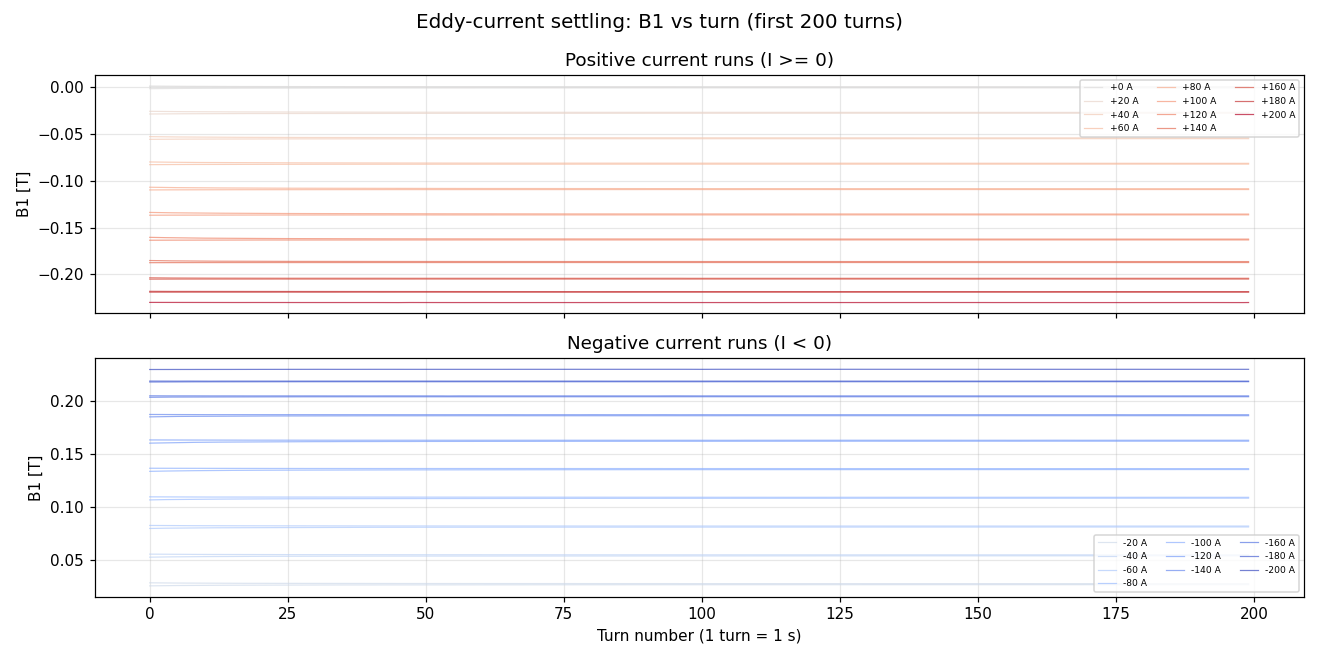

In [12]:
cmap = plt.cm.coolwarm
I_all_noms = sorted(df["I_nom"].unique())
norm_c = plt.Normalize(min(I_all_noms), max(I_all_noms))

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# Panel 1: positive current runs
ax = axes[0]
for run_id in sorted(df["run_id"].unique()):
    rdf = df[(df["run_id"] == run_id) & df["ok_main"]].sort_values("turn_in_run")
    if rdf.empty:
        continue
    I_nom = rdf["I_nom"].iloc[0]
    if I_nom < 0:
        continue
    first = rdf[rdf["turn_in_run"] < N_SHOW_SETTLING]
    if first.empty:
        continue
    color = cmap(norm_c(I_nom))
    ax.plot(first["turn_in_run"], first["B1_T"],
            "-", lw=0.8, color=color, alpha=0.7,
            label=f"{I_nom:+.0f} A" if run_id <= 10 else None)

ax.set_ylabel("B1 [T]")
ax.set_title("Positive current runs (I >= 0)")
ax.legend(fontsize=6, ncol=3, loc="upper right")

# Panel 2: negative current runs
ax = axes[1]
for run_id in sorted(df["run_id"].unique()):
    rdf = df[(df["run_id"] == run_id) & df["ok_main"]].sort_values("turn_in_run")
    if rdf.empty:
        continue
    I_nom = rdf["I_nom"].iloc[0]
    if I_nom >= 0:
        continue
    first = rdf[rdf["turn_in_run"] < N_SHOW_SETTLING]
    if first.empty:
        continue
    color = cmap(norm_c(I_nom))
    ax.plot(first["turn_in_run"], first["B1_T"],
            "-", lw=0.8, color=color, alpha=0.7,
            label=f"{I_nom:+.0f} A" if 21 <= run_id <= 30 else None)

ax.set_xlabel(f"Turn number (1 turn = {T_PER_TURN:.0f} s)")
ax.set_ylabel("B1 [T]")
ax.set_title("Negative current runs (I < 0)")
ax.legend(fontsize=6, ncol=3, loc="lower right")

fig.suptitle(f"Eddy-current settling: B1 vs turn (first {N_SHOW_SETTLING} turns)",
             fontsize=13)
fig.tight_layout()
plt.show()

## 6. Exponential Fit Methodology

### Model

$$B_1(t) = B_{1,\infty} + A \cdot \exp\!\left(-\frac{t}{\tau}\right)$$

where $t$ is in turns (= seconds at 60 rpm):
- $B_{1,\infty}$: asymptotic field (estimated from mean of last 50 turns)
- $A$: eddy-current amplitude at $t = 0$ (sign indicates overshoot vs undershoot)
- $\tau$: settling time constant [turns = seconds]

### Fit procedure

1. Estimate $B_{1,\infty}$ from the mean of the last 50 turns (well-settled)
2. Initial guess: $A_0 = B_1(0) - B_{1,\infty}$, $\tau_0 = 20$ turns
3. Fit using `scipy.optimize.curve_fit` with bounds $\tau \in [0.5, 500]$
4. Quality metric: $R^2$ and residual analysis

### Exclusions

- Runs with $|I_{\text{nom}}|$ < 10 A are excluded (residual field too small
  for meaningful eddy-current transient)

## 7. Fit Tau for Each Plateau

In [6]:
def eddy_model(t, B_inf, A, tau):
    """Exponential decay model for eddy-current settling."""
    return B_inf + A * np.exp(-t / tau)

MIN_R2 = 0.5  # quality threshold for accepting a fit

fit_records = []

for run_id in sorted(df["run_id"].unique()):
    rdf = df[(df["run_id"] == run_id) & df["ok_main"]].sort_values("turn_in_run")
    if rdf.empty:
        continue

    I_nom = rdf["I_nom"].iloc[0]
    branch = rdf["branch"].iloc[0]

    # Skip near-zero current runs
    if abs(I_nom) < MIN_I_FOR_FIT:
        continue

    turns = rdf["turn_in_run"].values.astype(float)
    B1 = rdf["B1_T"].values

    # Settled reference from last N_SETTLED turns
    B1_inf_est = B1[-N_SETTLED:].mean()

    # Initial guesses
    A_est = B1[0] - B1_inf_est
    tau_est = 20.0

    try:
        popt, pcov = curve_fit(
            eddy_model, turns, B1,
            p0=[B1_inf_est, A_est, tau_est],
            bounds=([-np.inf, -np.inf, 0.5], [np.inf, np.inf, 500]),
            maxfev=10000,
        )
        perr = np.sqrt(np.diag(pcov))
        B_inf, A, tau = popt

        # R^2 calculation
        B1_pred = eddy_model(turns, *popt)
        ss_res = np.sum((B1 - B1_pred) ** 2)
        ss_tot = np.sum((B1 - B1.mean()) ** 2)
        r2 = 1 - ss_res / ss_tot if ss_tot > 0 else 0.0

        fit_records.append({
            "run_id": run_id,
            "I_nom": I_nom,
            "abs_I": abs(I_nom),
            "branch": branch,
            "B1_inf": B_inf,
            "A": A,
            "tau": tau,
            "B1_inf_err": perr[0],
            "A_err": perr[1],
            "tau_err": perr[2],
            "r2": r2,
            "n_turns": len(turns),
        })
    except (RuntimeError, ValueError) as e:
        print(f"  Run {run_id:02d} ({I_nom:+7.1f} A): fit failed - {e}")

df_fits_all = pd.DataFrame(fit_records)

# Print full table with quality flag
print(f"Exponential fit results ({len(df_fits_all)} runs):")
print(f"{'Run':>4s} {'I [A]':>8s} {'Branch':>10s} {'tau [s]':>8s} "
      f"{'A [T]':>12s} {'B1_inf [T]':>12s} {'R2':>8s} {'':>6s}")
print("-" * 78)
for _, r in df_fits_all.iterrows():
    flag = " " if r["r2"] >= MIN_R2 else " *OUT*"
    print(f"{r['run_id']:4.0f} {r['I_nom']:+8.1f} {r['branch']:>10s} "
          f"{r['tau']:8.1f} {r['A']:+12.6f} {r['B1_inf']:+12.6f} "
          f"{r['r2']:8.4f}{flag}")

# Filter: keep only fits with R^2 >= MIN_R2
df_fits = df_fits_all[df_fits_all["r2"] >= MIN_R2].copy()
n_removed = len(df_fits_all) - len(df_fits)
print(f"\nRemoved {n_removed} outliers with R2 < {MIN_R2} "
      f"(runs {', '.join(str(int(r)) for r in df_fits_all.loc[df_fits_all['r2'] < MIN_R2, 'run_id'])})")
print(f"Retained {len(df_fits)} good fits")

Exponential fit results (38 runs):
 Run    I [A]     Branch  tau [s]        A [T]   B1_inf [T]       R2       
------------------------------------------------------------------------------
   1    +20.0  ascending     32.5    +0.001015    -0.026855   0.9818 
   2    +40.0  ascending     34.4    +0.001124    -0.054097   0.9797 
   3    +60.0  ascending     36.1    +0.001225    -0.081340   0.9783 
   4    +80.0  ascending     34.5    +0.001345    -0.108531   0.9786 
   5   +100.0  ascending     31.9    +0.001482    -0.135623   0.9809 
   6   +120.0  ascending     25.0    +0.001641    -0.162412   0.9843 
   7   +140.0  ascending     15.7    +0.001006    -0.186453   0.9788 
   8   +160.0  ascending     14.1    +0.000493    -0.204375   0.9264 
   9   +180.0  ascending     12.6    +0.000284    -0.218619   0.7969 
  10   +200.0  ascending     11.8    +0.000150    -0.230317   0.4913 *OUT*
  11   +180.0 descending      9.2    -0.000017    -0.219180   0.0116 *OUT*
  12   +160.0 descending      

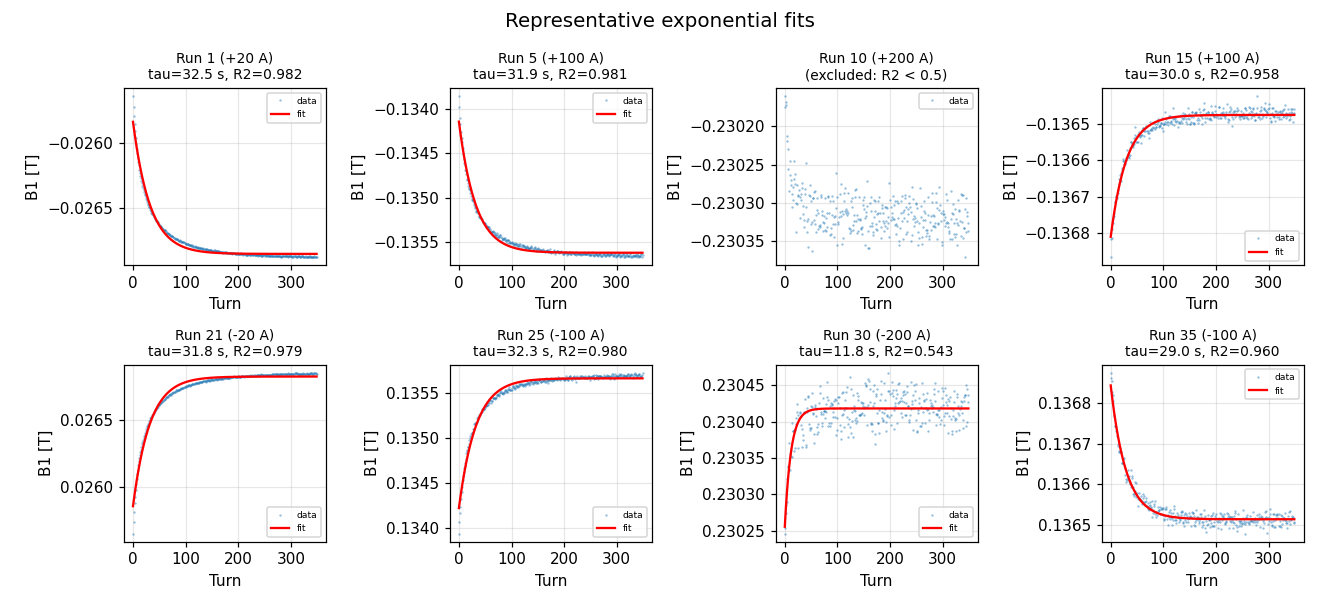

In [13]:
# Plot representative fits overlaid on data
show_runs = [1, 5, 10, 15, 21, 25, 30, 35]
n_show = len(show_runs)
n_cols = 4
n_rows = (n_show + n_cols - 1) // n_cols

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5.5))
axes_flat = axes.flatten()

for idx, run_id in enumerate(show_runs):
    ax = axes_flat[idx]
    rdf = df[(df["run_id"] == run_id) & df["ok_main"]].sort_values("turn_in_run")
    if rdf.empty:
        ax.set_visible(False)
        continue

    I_nom = rdf["I_nom"].iloc[0]
    turns = rdf["turn_in_run"].values.astype(float)
    B1 = rdf["B1_T"].values

    ax.plot(turns, B1, ".", ms=1, color="tab:blue", alpha=0.5, label="data")

    # Overlay fit if available
    fit_row = df_fits[df_fits["run_id"] == run_id]
    if not fit_row.empty:
        fr = fit_row.iloc[0]
        t_fit = np.linspace(0, turns.max(), 500)
        B1_fit = eddy_model(t_fit, fr["B1_inf"], fr["A"], fr["tau"])
        ax.plot(t_fit, B1_fit, "r-", lw=1.5, label="fit")
        ax.set_title(f"Run {run_id} ({I_nom:+.0f} A)\n"
                     f"tau={fr['tau']:.1f} s, R2={fr['r2']:.3f}",
                     fontsize=9)
    else:
        ax.set_title(f"Run {run_id} ({I_nom:+.0f} A)\n(excluded: R2 < {MIN_R2})",
                     fontsize=9)

    ax.set_xlabel("Turn")
    ax.set_ylabel("B1 [T]")
    ax.legend(fontsize=6)

# Hide unused axes
for idx in range(n_show, len(axes_flat)):
    axes_flat[idx].set_visible(False)

fig.suptitle("Representative exponential fits", fontsize=13)
fig.tight_layout()
plt.show()

## 8. Tau vs Current — The Permeability Effect

The settling time constant $\tau$ depends on the iron permeability $\mu_r(H)$:

$$\tau = \frac{\mu_0 \, \mu_r(H) \, \sigma \, d^2}{\pi^2}$$

- **Low current** (unsaturated iron): $\mu_r \approx 2000$–$5000$ → large $\tau$
- **High current** (approaching saturation): $\mu_r$ drops → $\tau$ decreases
- **Hysteresis**: ascending vs descending branches may show different $\tau$ at the
  same $|I|$ because the iron operates at different points on the B-H curve

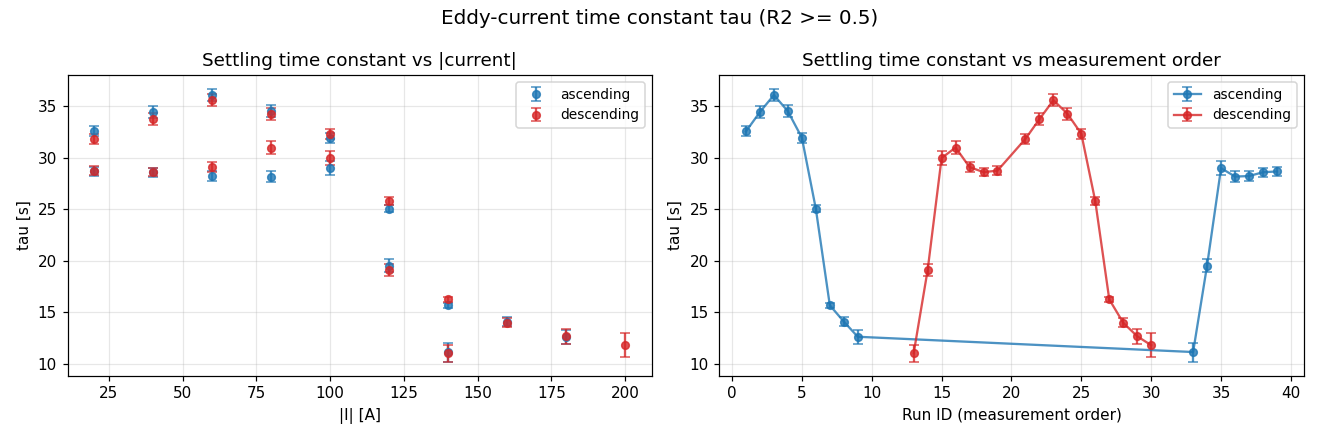


Tau statistics by |I| range (R2 >= 0.5, 33 runs):
  |I| in [ 10,  60) A: tau = 30.9 +/- 2.5 s (N=8, range 28.6 - 34.4)
  |I| in [ 60, 120) A: tau = 31.7 +/- 2.9 s (N=12, range 28.2 - 36.1)
  |I| in [120, 180) A: tau = 17.1 +/- 5.2 s (N=10, range 11.0 - 25.8)
  |I| in [180, 210) A: tau = 12.4 +/- 0.5 s (N=3, range 11.8 - 12.7)


In [14]:
branch_colors = {"ascending": "tab:blue", "descending": "tab:red"}

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# (a) tau vs |I|, colored by branch
ax = axes[0]
for branch, col in branch_colors.items():
    mask = df_fits["branch"] == branch
    if mask.any():
        ax.errorbar(df_fits.loc[mask, "abs_I"], df_fits.loc[mask, "tau"],
                    yerr=df_fits.loc[mask, "tau_err"],
                    fmt="o", color=col, ms=5, capsize=3, alpha=0.8,
                    label=branch)
ax.set_xlabel("|I| [A]")
ax.set_ylabel("tau [s]")
ax.set_title("Settling time constant vs |current|")
ax.legend(fontsize=9)

# (b) tau vs run order
ax = axes[1]
for branch, col in branch_colors.items():
    mask = df_fits["branch"] == branch
    if mask.any():
        ax.errorbar(df_fits.loc[mask, "run_id"], df_fits.loc[mask, "tau"],
                    yerr=df_fits.loc[mask, "tau_err"],
                    fmt="o-", color=col, ms=5, capsize=3, alpha=0.8,
                    label=branch)
ax.set_xlabel("Run ID (measurement order)")
ax.set_ylabel("tau [s]")
ax.set_title("Settling time constant vs measurement order")
ax.legend(fontsize=9)

fig.suptitle(f"Eddy-current time constant tau (R2 >= {MIN_R2})", fontsize=13)
fig.tight_layout()
plt.show()

# Print statistics by current range
print(f"\nTau statistics by |I| range (R2 >= {MIN_R2}, {len(df_fits)} runs):")
for lo, hi in [(10, 60), (60, 120), (120, 180), (180, 210)]:
    mask = (df_fits["abs_I"] >= lo) & (df_fits["abs_I"] < hi)
    if mask.any():
        tau_vals = df_fits.loc[mask, "tau"]
        print(f"  |I| in [{lo:3d}, {hi:3d}) A: "
              f"tau = {tau_vals.mean():.1f} +/- {tau_vals.std():.1f} s "
              f"(N={mask.sum()}, range {tau_vals.min():.1f} - {tau_vals.max():.1f})")

## 9. Impact on Harmonics — Settling Bias in Units

For each run, compare the mean B1/b2/b3 of the early turns (still settling)
vs the settled reference (last 50 turns). This quantifies the systematic bias
introduced by eddy currents and directly informs the `N_LAST_TURNS` choice.

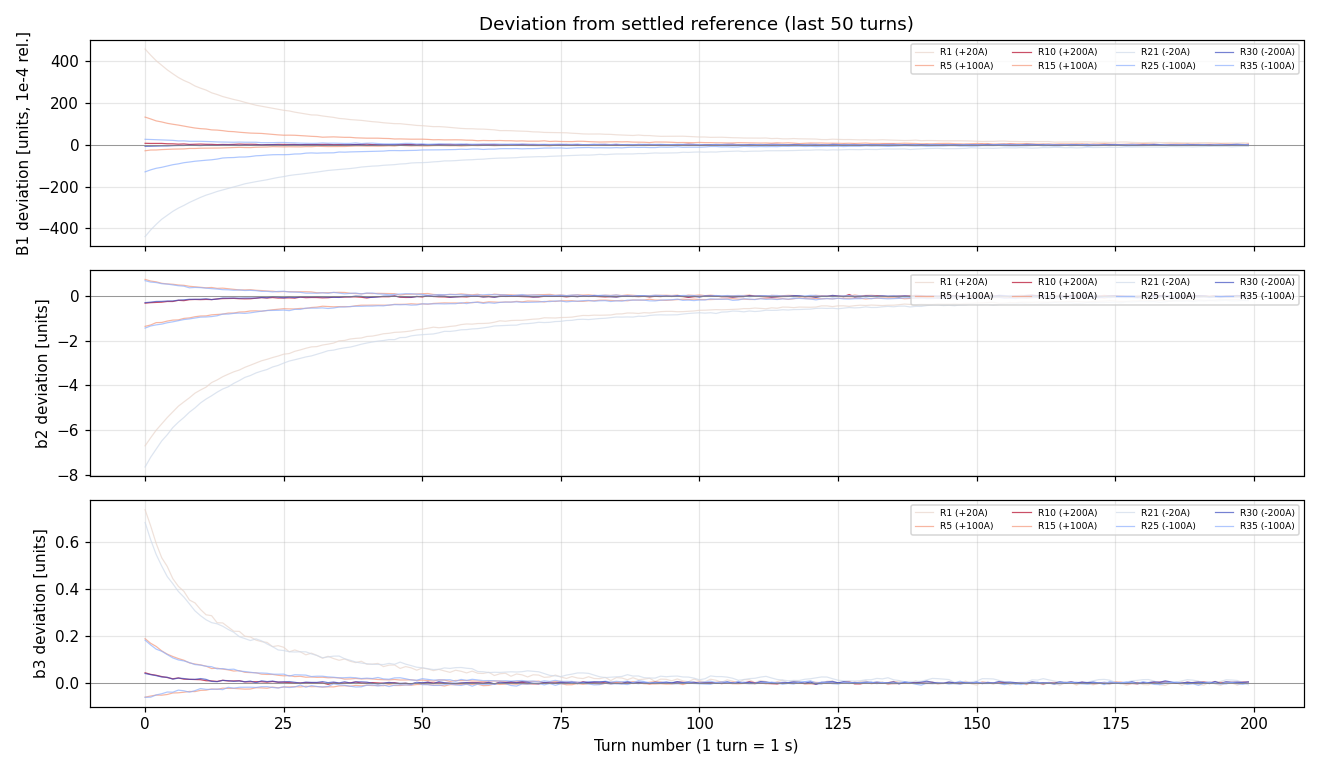

In [15]:
fig, axes = plt.subplots(3, 1, figsize=(12, 7), sharex=True)

show_runs_dev = [1, 5, 10, 15, 21, 25, 30, 35]

for quantity, col_name, ax, ylabel in [
    ("B1", "B1_T", axes[0], "B1 deviation [units, 1e-4 rel.]"),
    ("b2", "b2_units", axes[1], "b2 deviation [units]"),
    ("b3", "b3_units", axes[2], "b3 deviation [units]"),
]:
    for run_id in show_runs_dev:
        rdf = df[(df["run_id"] == run_id) & df["ok_main"]].sort_values("turn_in_run")
        if rdf.empty or col_name not in rdf.columns:
            continue
        I_nom = rdf["I_nom"].iloc[0]
        if abs(I_nom) < MIN_I_FOR_FIT:
            continue

        vals = rdf[col_name].values
        turns = rdf["turn_in_run"].values

        # Reference: last N_SETTLED turns
        ref = vals[-N_SETTLED:].mean()

        if quantity == "B1":
            # Express as units (1e-4 relative)
            if abs(ref) > 1e-10:
                dev = 1e4 * (vals - ref) / abs(ref)
            else:
                continue
        else:
            dev = vals - ref

        # Show first N_SHOW_SETTLING turns
        mask = turns < N_SHOW_SETTLING
        color = cmap(norm_c(I_nom))
        ax.plot(turns[mask], dev[mask], "-", lw=0.8, color=color, alpha=0.7,
                label=f"R{run_id} ({I_nom:+.0f}A)")

    ax.set_ylabel(ylabel)
    ax.axhline(0, color="gray", lw=0.5)
    ax.legend(fontsize=6, ncol=4, loc="upper right")

axes[0].set_title("Deviation from settled reference (last 50 turns)")
axes[-1].set_xlabel(f"Turn number (1 turn = {T_PER_TURN:.0f} s)")

fig.tight_layout()
plt.show()

## 10. Sensitivity Study — N_LAST_TURNS

Sweep `N_LAST_TURNS` from 50 to 330 and compute the mean B1 and b3 across
all non-zero runs. This shows how much systematic bias remains as a function
of the averaging window.

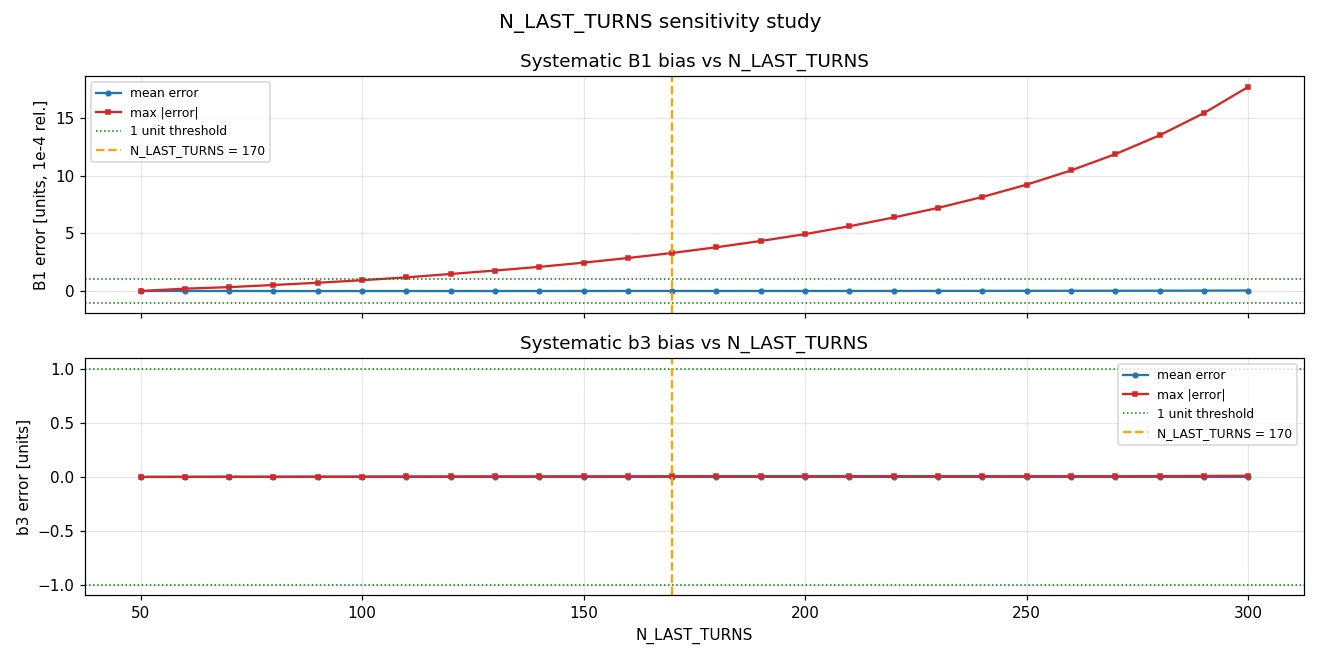


Key N_LAST_TURNS values:
  N_LAST_TURNS = 100: B1 max |error| = 0.94 units, b3 max |error| = 0.00 units
  N_LAST_TURNS = 150: B1 max |error| = 2.46 units, b3 max |error| = 0.01 units
  N_LAST_TURNS = 170: B1 max |error| = 3.29 units, b3 max |error| = 0.01 units
  N_LAST_TURNS = 200: B1 max |error| = 4.93 units, b3 max |error| = 0.01 units
  N_LAST_TURNS = 250: B1 max |error| = 9.22 units, b3 max |error| = 0.01 units
  N_LAST_TURNS = 300: B1 max |error| = 17.69 units, b3 max |error| = 0.01 units


In [16]:
n_last_values = np.arange(50, 331, 10)
study_runs_ids = [r["run_id"] for r in runs_integral
                  if abs(r["I_nom"]) >= MIN_I_FOR_FIT]

# For each N_LAST, compute mean B1 error and b3 error relative to fully settled
results_sweep = []

for n_last in n_last_values:
    B1_errors = []
    b3_errors = []

    for run_id in study_runs_ids:
        rdf = df[(df["run_id"] == run_id) & df["ok_main"]].sort_values("turn_in_run")
        if len(rdf) < n_last + N_SETTLED:
            continue

        # "Settled" reference: last N_SETTLED turns
        B1_ref = rdf["B1_T"].iloc[-N_SETTLED:].mean()

        # "Selected" average: last n_last turns
        B1_sel = rdf["B1_T"].iloc[-n_last:].mean()

        if abs(B1_ref) > 1e-10:
            B1_errors.append(1e4 * (B1_sel - B1_ref) / abs(B1_ref))  # units

        if "b3_units" in rdf.columns:
            b3_ref = rdf["b3_units"].iloc[-N_SETTLED:].mean()
            b3_sel = rdf["b3_units"].iloc[-n_last:].mean()
            b3_errors.append(b3_sel - b3_ref)

    results_sweep.append({
        "n_last": n_last,
        "B1_mean_error": np.mean(B1_errors) if B1_errors else np.nan,
        "B1_max_error": np.max(np.abs(B1_errors)) if B1_errors else np.nan,
        "b3_mean_error": np.mean(b3_errors) if b3_errors else np.nan,
        "b3_max_error": np.max(np.abs(b3_errors)) if b3_errors else np.nan,
    })

df_sweep = pd.DataFrame(results_sweep)

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)

# B1 error
ax = axes[0]
ax.plot(df_sweep["n_last"], df_sweep["B1_mean_error"], "o-", ms=3,
        color="tab:blue", label="mean error")
ax.plot(df_sweep["n_last"], df_sweep["B1_max_error"], "s-", ms=3,
        color="tab:red", label="max |error|")
ax.axhline(1, color="green", ls=":", lw=1, label="1 unit threshold")
ax.axhline(-1, color="green", ls=":", lw=1)
ax.axvline(170, color="orange", ls="--", lw=1.5, label="N_LAST_TURNS = 170")
ax.set_ylabel("B1 error [units, 1e-4 rel.]")
ax.set_title("Systematic B1 bias vs N_LAST_TURNS")
ax.legend(fontsize=8)

# b3 error
ax = axes[1]
ax.plot(df_sweep["n_last"], df_sweep["b3_mean_error"], "o-", ms=3,
        color="tab:blue", label="mean error")
ax.plot(df_sweep["n_last"], df_sweep["b3_max_error"], "s-", ms=3,
        color="tab:red", label="max |error|")
ax.axhline(1, color="green", ls=":", lw=1, label="1 unit threshold")
ax.axhline(-1, color="green", ls=":", lw=1)
ax.axvline(170, color="orange", ls="--", lw=1.5, label="N_LAST_TURNS = 170")
ax.set_xlabel("N_LAST_TURNS")
ax.set_ylabel("b3 error [units]")
ax.set_title("Systematic b3 bias vs N_LAST_TURNS")
ax.legend(fontsize=8)

fig.suptitle("N_LAST_TURNS sensitivity study", fontsize=13)
fig.tight_layout()
plt.show()

# Print key values
print("\nKey N_LAST_TURNS values:")
for n_check in [100, 150, 170, 200, 250, 300]:
    row = df_sweep[df_sweep["n_last"] == n_check]
    if not row.empty:
        r = row.iloc[0]
        print(f"  N_LAST_TURNS = {n_check:3d}: "
              f"B1 max |error| = {r['B1_max_error']:.2f} units, "
              f"b3 max |error| = {r['b3_max_error']:.2f} units")

## 11. Observations & Recommendations

### Settling Time Constants

- **Expected range**: tau varies from ~5 s (high current, low mu_r) to
  ~30+ s (low current, high mu_r) for laminated iron yoke magnets
- **Current dependence**: tau decreases with |I| as iron approaches saturation
  (mu_r drops)
- **Hysteresis**: ascending and descending branches may show slightly different
  tau values at the same |I| due to different magnetic history

### N_LAST_TURNS = 170

With 350 turns per plateau:
- Skipping the first 180 turns (= 180 s = 6-10x tau) ensures the eddy-current
  transient has decayed to < 1 unit for all current levels
- The last 170 turns provide sufficient statistics (sigma/sqrt(N) improvement)
- This is conservative: at high current, settling is faster (< 100 turns needed)

### Recommendations for Future Measurements

- **Low current**: if tau > 30 s at |I| < 40 A, consider longer plateaus
  (500+ turns) to improve settling characterization
- **Waiting time**: after large current steps, allow at least 5x tau before
  starting the measurement to minimize transient contamination

## 12. Summary Table

In [11]:
print("=" * 80)
print(f"  Eddy Current Settling -- Summary (R2 >= {MIN_R2})")
print("=" * 80)
print(f"{'Run':>4s} {'I [A]':>8s} {'Branch':>10s} {'tau [s]':>8s} "
      f"{'tau_err':>8s} {'A [T]':>12s} {'R2':>8s}")
print("-" * 72)
for _, r in df_fits.iterrows():
    print(f"{r['run_id']:4.0f} {r['I_nom']:+8.1f} {r['branch']:>10s} "
          f"{r['tau']:8.1f} {r['tau_err']:8.1f} "
          f"{r['A']:+12.6f} {r['r2']:8.4f}")

print(f"\n{'=' * 80}")
print(f"  {len(df_fits)} runs retained (of {len(df_fits_all)} total)")
tau_all = df_fits["tau"]
print(f"  tau range: {tau_all.min():.1f} - {tau_all.max():.1f} s")
print(f"  tau mean:  {tau_all.mean():.1f} +/- {tau_all.std():.1f} s")
print(f"  R2 range:  {df_fits['r2'].min():.4f} - {df_fits['r2'].max():.4f}")

  Eddy Current Settling -- Summary (R2 >= 0.5)
 Run    I [A]     Branch  tau [s]  tau_err        A [T]       R2
------------------------------------------------------------------------
   1    +20.0  ascending     32.5      0.5    +0.001015   0.9818
   2    +40.0  ascending     34.4      0.5    +0.001124   0.9797
   3    +60.0  ascending     36.1      0.6    +0.001225   0.9783
   4    +80.0  ascending     34.5      0.6    +0.001345   0.9786
   5   +100.0  ascending     31.9      0.5    +0.001482   0.9809
   6   +120.0  ascending     25.0      0.3    +0.001641   0.9843
   7   +140.0  ascending     15.7      0.2    +0.001006   0.9788
   8   +160.0  ascending     14.1      0.4    +0.000493   0.9264
   9   +180.0  ascending     12.6      0.7    +0.000284   0.7969
  13   +140.0 descending     11.0      0.8    -0.000179   0.6638
  14   +120.0 descending     19.1      0.6    -0.000316   0.9256
  15   +100.0 descending     30.0      0.7    -0.000334   0.9582
  16    +80.0 descending     31.0  